In [6]:
import attk
import os
import csv
import numpy as np
import librosa
import timeit
import random
import subprocess
import urllib2
from sklearn.externals import joblib
from numpy import ma
from aubio import source, pitch
from moviepy.audio.io import AudioFileClip
from IPython.display import display, Audio

os.chdir('/sharedfolder/sida_classifier/')

class_list = ['Bill Clinton', 'Male', 'Female']

class_0_label, class_1_label, class_2_label = class_list

In [7]:
## Load saved features

def load_features(dir_path):
    features = []
    for filename in os.listdir(dir_path):
        with open(os.path.join(dir_path, filename)) as fi:
            csv_reader = csv.reader(fi)
            for row in csv_reader:
                features.append([float(item) for item in row])
    return features

class_0_features = load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/Bill_Clinton/_vowel_mfccs_and_deltas')
print(len(class_0_features))

class_1_features = load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/Male_AAPB_171110/_vowel_mfccs_and_deltas')
class_1_features += load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/males_5k/_vowel_mfccs_and_deltas')
print(len(class_1_features))

class_2_features = load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/Female_AAPB_171110/_vowel_mfccs_and_deltas')
class_2_features += load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/females_5k/_vowel_mfccs_and_deltas')
print(len(class_2_features))


## Downsampling each class to the size of the smallest in the set

min_length = np.min([len(class_0_features), len(class_1_features), len(class_2_features)])

try: class_0_features = random.sample(class_0_features, min_length)
except: pass
try: class_1_features = random.sample(class_1_features, min_length)
except: pass
try: class_2_features = random.sample(class_2_features, min_length)
except: pass

#aapb_ubm_male_features = load_features('/sharedfolder/sida_classifier/AAPB_male_vowel_mfccs_and_deltas_100-5K_Hz')
#print(len(aapb_ubm_male_features))

#aapb_ubm_female_features = load_features('/sharedfolder/sida_classifier/AAPB_female_vowel_mfccs_and_deltas_100-5K_Hz')
#print(len(aapb_ubm_female_features))

12095
85262
98514


In [8]:
## Printing MFCCs and deltas for a single frame

print(random.choice(class_0_features))

[146.63324174721177, -18.356080075541108, 16.46353648091029, 20.00061328200847, 27.90976790279207, 11.529243602372674, 1.8592964080732948, 10.222931505442055, -15.021521379951455, -16.821926589261782, -5.5679406500201125, -4.1096195660764, -7.818174134636181, 2.0396600998036956, -12.778588837129673, -9.34969239347669, 15.279748942448103, 7.36035577205557, -2.528116536011712, 4.380640596011527, 6.494094004932944, 5.789742426330707, 6.109516975066917, 14.856108432765065, 13.456224459656037, -5.112674430113556, -6.020728864628027, 5.249928704344256, 0.20027234947766326, 1.1053556949284307, -5.606510554510557, -4.790992692244583, 0.09698640187660734, 2.3333657351202914, 4.164120226866212, 2.028917323714955, -2.672765892585301, -4.368943897920444, -2.361895877929004, -2.619626435992301, -0.09519958639782572, 3.3167069752449727, -0.19888242157906377, -2.749651041073347, 0.373882938122997, -0.9830420016635666, 0.020776485290564417, 0.9015176521573591, -1.0883034759159567, -1.692364960102697, 

In [9]:
## Training and multi-layer perceptron model with 9/10 of training data 
# and evaluating performance on remaining 1/10

os.chdir('/sharedfolder/sida_classifier/')

import random

from sklearn.neural_network import MLPClassifier

X = class_0_features[:-len(class_0_features)/10] + \
    class_1_features[:-len(class_1_features)/10] + \
    class_2_features[:-len(class_2_features)/10]

y = [1]*len(class_0_features[:-len(class_0_features)/10]) + \
    [0]*len(class_1_features[:-len(class_1_features)/10]) + \
    [2]*len(class_2_features[:-len(class_2_features)/10])

X_train = np.array(X)
y_train = np.array(y)

X_test = class_0_features[-len(class_0_features)/10:] + class_1_features[-len(class_1_features)/10:] + \
    class_2_features[-len(class_2_features)/10:]
y_test = [1]*len(class_0_features[-len(class_0_features)/10:]) + \
    [0]*len(class_1_features[-len(class_1_features)/10:]) + \
    [2]*len(class_2_features[-len(class_2_features)/10:])

X_test = np.array(X_test)
y_test = np.array(y_test)
    
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = MLPClassifier(max_iter = 2000, random_state = 9, \
                          hidden_layer_sizes = (100, 100), solver = 'adam', \
                          activation = 'relu').fit(X_train_scaled, y_train)

print(classifier.score(X_test_scaled,y_test))

0.7234159779614325


In [52]:
## Training and saving MLPC model and scaler with all training data

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

X = class_0_features + class_1_features + class_2_features
y = [0]*len(class_0_features) + [1]*len(class_1_features) + [2]*len(class_2_features) 

scaler = StandardScaler()

scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

X_scaled = scaler.transform(X)

#classifier = MLPClassifier().fit(X_scaled, y)

classifier = MLPClassifier(max_iter = 2000, random_state = 9, \
                          hidden_layer_sizes = (100, 100), solver = 'adam', \
                          activation = 'relu').fit(X_scaled, y)

trained_model_filename = 'BC' + '_vowels_mlpc_4096_100-16K_scaled_171116.pkl'
scaler_filename = trained_model_filename.replace('.pkl', '.scaler')

print(trained_model_filename)
print(scaler_filename)

## Saving trained model
joblib.dump(classifier, trained_model_filename)
joblib.dump(scaler, scaler_filename)
classifier = joblib.load(trained_model_filename)
scaler = joblib.load(scaler_filename)

BC_vowels_mlpc_4096_100-16K_scaled_171116.pkl


In [53]:
##############################################
#### Start here to load pre-trained model ####
##############################################

#trained_model_filename = 'mbmbam' + '_vowels_mlpc_4096_100-5K_scaled.pkl'

#os.chdir('/sharedfolder/sida_classifier_mbmbam_v2/')
#classifier = joblib.load(trained_model_filename)

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs

from pandas.tools.plotting import parallel_coordinates

In [55]:
## Flattening data to 2 dimensions with linear discriminant analysis (LDA) for visualization

lda = LDA(n_components=2) #2-dimensional LDA
lda_transformed = pd.DataFrame(lda.fit_transform(X_scaled, y))
lda_transformed.tail()

,0,1
195866,0.758477,-0.540869
195867,0.111188,-1.851101
195868,0.381831,0.272241
195869,-0.650632,-0.392098
195870,-0.224055,-0.025816


In [56]:
lda_transformed['y'] = y

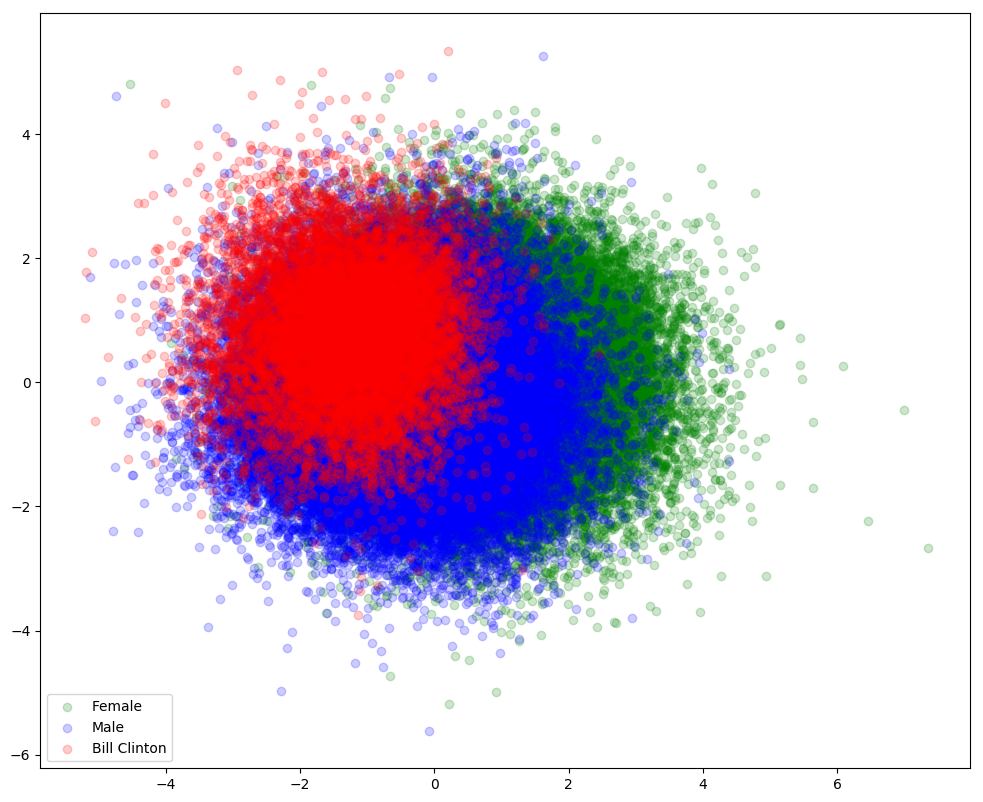

In [57]:
# 30 mfccs, 81

plt.figure(figsize=(12, 10), dpi=100)

plt.scatter(lda_transformed[lda_transformed['y']==2][0], lda_transformed[lda_transformed['y']==2][1], label='Female', c='green', alpha=0.2)
plt.scatter(lda_transformed[lda_transformed['y']==1][0], lda_transformed[lda_transformed['y']==1][1], label='Male', c='blue', alpha=0.2)

#plt.scatter(lda_transformed[lda_transformed['y']==3][0], lda_transformed[lda_transformed['y']==3][1], label='Music', c='orange', alpha=0.2)
plt.scatter(lda_transformed[lda_transformed['y']==0][0], lda_transformed[lda_transformed['y']==0][1], label='Bill Clinton', c='red', alpha=0.2)


plt.legend(loc=3)
plt.show()

In [58]:
def most_common_class(class_ids):
    mode_id = int(list(scipy.stats.mode(class_ids))[0][0])
    mode_id_percentage = float(float(class_ids.count(mode_id))/len(class_ids))
    return (mode_id, mode_id_percentage)

In [59]:
#%%capture
## Download unseen audio and split into 3-second WAV clips for testing


clip_path = '/sharedfolder/sida_classifier/test_clips/'

os.chdir(clip_path)

wav_filename = 'Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4.wav'

#wav_filename = mp3_filename[:-4]+'.wav'

subprocess.call(['ffmpeg', '-i', mp3_filename, wav_filename])

subprocess.call(['ffmpeg', '-i', wav_filename, '-f', 'segment', '-segment_time', '3',  wav_filename[:-4] + '_3_sec_%04d.wav'])


0

In [60]:
## Classifying short clips
#### Repeat this cell several times to help choose a classifier threshold value.

import scipy

os.chdir('/sharedfolder/sida_classifier/test_clips/')

wav_pathname = os.path.abspath(random.choice([item for item in os.listdir('./') if '3_sec' in item]))

test_features = np.array(attk.get_mfccs_and_deltas(wav_pathname, n_mfcc=30, n_fft=8192))
test_features = scaler.transform(test_features)

print(wav_pathname)

results = classifier.predict(test_features)  ## Predicting new observation
results_proba = classifier.predict_proba(test_features)  ## Predicting new observation

print(results)
print([round(max(item), 4) for item in list(results_proba)])

vowel_results=[]

vowel_bools = attk.get_vowel_segments(wav_pathname, n_fft=8192)

for i in range(len(results)):
    if vowel_bools[i]==True:
        vowel_results.append(results[i])

display(Audio(wav_pathname))

print("MODE: " + str(list(scipy.stats.mode(results))[0][0])) 
print("MODE vowels only: " + str(list(scipy.stats.mode(vowel_results))[0][0])) ## Vowels only
#print("All samples: "+str(np.mean(results)))
#print("Vowels only: "+str(np.mean(vowel_results)))

mode_id, mode_id_percentage = most_common_class(vowel_results)
top_label = class_list[mode_id]

print('')
print("Speaker: " + str(top_label))
print("Confidence: " + str(mode_id_percentage))

print('')

print(str(mode_id) +','+ str(mode_id_percentage) + ',' + str(top_label) + '\n')

/sharedfolder/sida_classifier/test_clips/bill-clinton-dedication-of-the-jfk-library-boston-10-23-1993_3_sec_0074.wav
[0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0]
[1.0, 0.9197, 0.5795, 0.9047, 0.8041, 0.9524, 0.9193, 0.7308, 0.9226, 0.9246, 0.8336, 0.9873, 0.8945, 0.9928, 0.5252, 0.6542, 0.694]


MODE: 1
MODE vowels only: 1

Speaker: Male
Confidence: 0.8

1,0.8,Male



In [61]:
## Function that classifies vowel segments only and returns 
## average output for the full clip

def classify_clip(clip_pathname):
    mfccs = np.array(attk.get_mfccs_and_deltas(clip_pathname, n_mfcc=30, n_fft=8192))
    mfccs = scaler.transform(mfccs)
    results = classifier.predict(mfccs)  ## Predicting new observation
    vowel_results=[]
    vowel_bools = attk.get_vowel_segments(clip_pathname, n_fft=8192)
    #print(len(mfccs))
    #print(len(results))
    #print(len(vowel_bools))
    
    if len(vowel_bools)==0:
            return most_common_class(results)
        
    for i in range(len(results)):
        if vowel_bools[i]==True:
            vowel_results.append(results[i])

    return  most_common_class(vowel_results)

In [62]:
import scipy
os.chdir('/sharedfolder/sida_classifier/test_clips/')
!rm *_3_sec_*

In [44]:
!youtube-dl --extract-audio --audio-format wav https://www.youtube.com/watch?v=SS8reX-i8j4

[youtube] SS8reX-i8j4: Downloading webpage
[youtube] SS8reX-i8j4: Downloading video info webpage
[youtube] SS8reX-i8j4: Extracting video information
[youtube] SS8reX-i8j4: Downloading MPD manifest
[youtube] SS8reX-i8j4: Downloading MPD manifest
[dashsegments] Total fragments: 379
[download] Destination: Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4.m4a
[download] 100% of 28.63MiB in 00:25.60MiB/s ETA 00:00045:12
[ffmpeg] Correcting container in "Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4.m4a"
[ffmpeg] Destination: Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4.wav
Deleting original file Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4.m4a (pass -k to keep)


In [ ]:
%%capture
## Classifying a long audio file

resolution_secs = 3
classifier_threshold = 0.30

os.chdir('/sharedfolder/sida_classifier/Larry_Monroe/')

errors = []

import datetime

import timeit
tic=timeit.default_timer()


media_path = random.choice([item for item in os.listdir('./') if '.mp3' in item])
media_path = 'Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4.wav'

time_str = str(datetime.datetime.now()).replace(':', '').split('.')[0].replace(' ', '_')

csv_path = media_path[:-4]+'_mlpc4096_labels_100-1600Hz_scaled_'+str(resolution_secs)+'s_' + time_str +'.csv'

snd = AudioFileClip.AudioFileClip(media_path)

classifications = []
with open(csv_path,'w') as fo:
    fo.write('')

for i in range(int(attk.duration(media_path)/resolution_secs)):
    try:
        snd.subclip(i * resolution_secs , (i * resolution_secs) + resolution_secs).write_audiofile('/tmp/temp_clip.wav')
        mode_id, mode_id_percentage = classify_clip('/tmp/temp_clip.wav')
        os.remove('/tmp/temp_clip.wav')
        
        top_label = class_list[mode_id]
        if mode_id_percentage > classifier_threshold:
            with open(csv_path,'a') as fo:
                duration = resolution_secs
                start = i * resolution_secs
                fo.write(str(start) + ',' + str(duration) +','+ str(mode_id) +','+ str(mode_id_percentage) + ',' + str(top_label) + '\n')
    except Exception as e:
        errors.append(e)
        print("Error: " + str(i))
        print(e)

In [63]:
%%capture
## Batch classifying audio files

resolution_secs = 3
classifier_threshold = 0.30

os.chdir('/sharedfolder/sida_classifier/test_clips/')

errors = []

import datetime

import timeit
tic=timeit.default_timer()


wav_filenames = [item for item in os.listdir('./') if ('.wav' in item)&(item[0]!='.')]

random.shuffle(wav_filenames)

for media_path in wav_filenames:

    time_str = str(datetime.datetime.now()).replace(':', '').split('.')[0].replace(' ', '_')

    csv_path = media_path[:-4]+'_mlpc4096_labels_100-1600Hz_scaled_'+str(resolution_secs)+'s_' + time_str +'.csv'

    snd = AudioFileClip.AudioFileClip(media_path)

    classifications = []
    with open(csv_path,'w') as fo:
        fo.write('')

    for i in range(int(attk.duration(media_path)/resolution_secs)):
        try:
            snd.subclip(i * resolution_secs , (i * resolution_secs) + resolution_secs).write_audiofile('/tmp/temp_clip.wav')
            mode_id, mode_id_percentage = classify_clip('/tmp/temp_clip.wav')
            os.remove('/tmp/temp_clip.wav')

            top_label = class_list[mode_id]
            if mode_id_percentage > classifier_threshold:
                with open(csv_path,'a') as fo:
                    duration = resolution_secs
                    start = i * resolution_secs
                    fo.write(str(start) + ',' + str(duration) +','+ str(mode_id) +','+ str(mode_id_percentage) + ',' + str(top_label) + '\n')
        except Exception as e:
            errors.append(e)
            print("Error: " + str(i))
            print(e)

In [64]:
print("Time elapsed: "+str(timeit.default_timer() - tic))
os.system("printf '\a'")

Time elapsed: 170.517322063


0

In [47]:
print(len(errors))
print(list(set([item[0] for item in errors])))

5
['index 0 is out of bounds for axis 0 with size 0']
